Thanks to: Sebastian Raschka (sraschka@wisc.edu) 

# Regresión Softmax para MNIST

Implementación de regresión softmax (regresión logística multinomial)

## Importar módulos

In [1]:
import time

from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
import matplotlib
import matplotlib.pyplot as plt

## Configuraciones y Dataset

In [2]:
##########################
### CONFIGURACIÓN
##########################

# Device (dispositivo, de esta manera se usa gpu de forma automática si está disponible)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hiperparámetros
random_seed = 123
learning_rate = 0.1
num_epochs = 25
batch_size = 256

# Arquitectura
num_features = 784
num_classes = 10


##########################
### MNIST DATASET
##########################

train_dataset = datasets.MNIST(root='data', #nombre de carpeta a crear
                               train=True, # True si se desea descargar conjunto de entrenamiento
                               transform=transforms.ToTensor(), # Se pasan a tipo Tensor de PyTorch
                                                        #ToTensor escala las imágenes de entrada al rango 0-1
                               download=True) # Si se desea descargar

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())

#Creación de DataLoader de train y test
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True) # Importante revolver

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)


# Verificar dimensiones
for images, labels in train_loader:  
    print('Dimensiones de batch de imágenes:', images.shape) #En pytorch se organizan: NCHW
    print('Dimensiones de batch de etiquetas:', labels.shape)
    break

Dimensiones de batch de imágenes: torch.Size([256, 1, 28, 28])
Dimensiones de batch para etiquetas: torch.Size([256])


In [3]:
device

device(type='cpu')

In [4]:
##########################
### MODELO
##########################

class SoftmaxRegression(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super(SoftmaxRegression, self).__init__()
        self.linear = torch.nn.Linear(num_features, num_classes) #num_features en la capa de entrada, num_classes en la de salida
                
    def forward(self, x): #Paso hacia adelante
        logits = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

#Instanciar modelo
model = SoftmaxRegression(num_features=num_features,
                          num_classes=num_classes)

model.to(device)

##########################
### OPTIMIZADOR
##########################

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

In [5]:
# Se establece una semilla para repetibilidad
torch.manual_seed(random_seed)

def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    
    for features, targets in data_loader:
        features = features.view(-1, 28*28).to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.shape[0]
        correct_pred += (predicted_labels == targets).sum()
        
    return correct_pred.float() / num_examples * 100

##########################
### ENTRENAMIENTO
##########################

start_time = time.time()
epoch_costs = []
for epoch in range(num_epochs):
    avg_cost = 0.
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
        targets = targets.to(device)
            
        ### PASO HACIA ADELANTE Y PROPAGACIÓN HACIA ATRÁS
        logits, probas = model(features)
        
        # La implementación de CrossEntropyLoss en
        # PyTorch funciona con logits, no probabilidades
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad() #Gradientes cero
        cost.backward() #Paso hacia atrás
        avg_cost += cost
        
        ### Actualización de parámetros del modelo (GD)
        optimizer.step()
        
        ### Registro
        if not batch_idx % 50:
            print (f'Época: {epoch+1:03d}/{num_epochs:03d} | Batch {batch_idx:03d}/{len(train_dataset)//batch_size} | Costo: {cost:.4f}')
            
    with torch.set_grad_enabled(False):
        avg_cost = avg_cost/len(train_dataset)
        epoch_costs.append(avg_cost)
        print(f'Época: {epoch+1:03d}/{num_epochs:03d} exactitud en entrenamiento: {compute_accuracy(model, train_loader):.2f}%')
        print(f'Tiempo transcurrido: {((time.time() - start_time)/60):.2f} min')

Época: 001/025 | Batch 000/234 | Costo: 2.3445
Época: 001/025 | Batch 050/234 | Costo: 0.7756
Época: 001/025 | Batch 100/234 | Costo: 0.5345
Época: 001/025 | Batch 150/234 | Costo: 0.5586
Época: 001/025 | Batch 200/234 | Costo: 0.5512
Época: 001/025 exactitud en entrenamiento: 88.06%
Tiempo transcurrido: 0.36 min
Época: 002/025 | Batch 000/234 | Costo: 0.4842
Época: 002/025 | Batch 050/234 | Costo: 0.3671
Época: 002/025 | Batch 100/234 | Costo: 0.4552
Época: 002/025 | Batch 150/234 | Costo: 0.3774
Época: 002/025 | Batch 200/234 | Costo: 0.4808
Época: 002/025 exactitud en entrenamiento: 89.24%
Tiempo transcurrido: 0.72 min
Época: 003/025 | Batch 000/234 | Costo: 0.4070
Época: 003/025 | Batch 050/234 | Costo: 0.4457
Época: 003/025 | Batch 100/234 | Costo: 0.3775
Época: 003/025 | Batch 150/234 | Costo: 0.3894
Época: 003/025 | Batch 200/234 | Costo: 0.3000
Época: 003/025 exactitud en entrenamiento: 89.97%
Tiempo transcurrido: 1.07 min
Época: 004/025 | Batch 000/234 | Costo: 0.4325
Época: 0

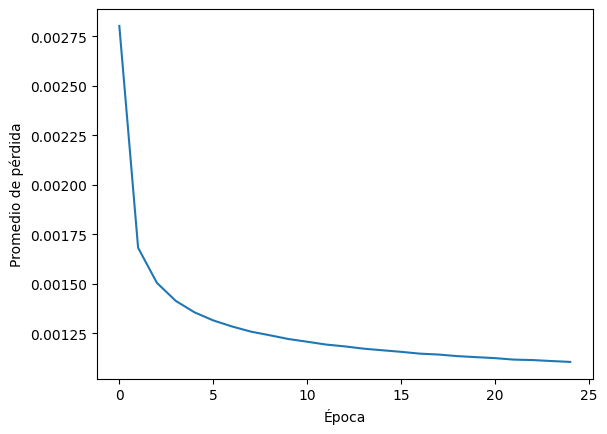

In [6]:
plt.plot(epoch_costs)
plt.ylabel('Promedio de pérdida')
plt.xlabel('Época')
plt.show()

In [13]:
print(f'Exactitud de Test: {(compute_accuracy(model, test_loader)):.2f}%' )

Exactitud de Test: 92.28%


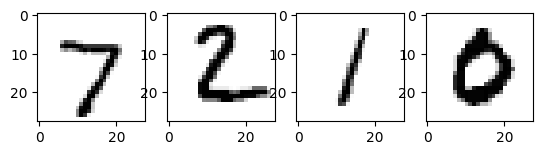

In [18]:
for features, targets in test_loader:
    break
    
fig, ax = plt.subplots(1, 4)
for i in range(4):
    ax[i].imshow(features[i].view(28, 28), cmap=matplotlib.cm.binary)

plt.show()

In [19]:
_, predictions = model.forward(features[:4].view(-1, 28*28).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Etiquetas predichas:', predictions)
print('Etiquetas reales:',targets[:4])

Etiquetas predichas: tensor([7, 2, 1, 0])
Etiquetas reales: tensor([7, 2, 1, 0])


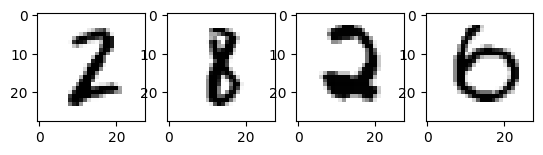

Etiquetas predichas: tensor([2, 8, 2, 0])
Etiquetas reales: tensor([2, 8, 2, 6])


In [20]:
TL = iter(test_loader) #para iterar el test dataloader manualmente
_ = next(TL); 
# _ = next(TL)
# _ = next(TL)
features, targets = next(TL)
fig, ax = plt.subplots(1, 4)
for i in range(4):
    ax[i].imshow(features[i].view(28, 28), cmap=matplotlib.cm.binary)

plt.show()

_, predictions = model.forward(features[:4].view(-1, 28*28).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Etiquetas predichas:', predictions)
print('Etiquetas reales:',targets[:4])